<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 30px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Datos No Estructurados: IMAGEN</h1>
        <h2 style="color: white; text-align: center;">Clasificador de Melanoma</h2>
    </div>

</div>

<div style="padding: 5px;">
    <h3 style="color: #1e355f; font-weight: bold;">Realizado por:</h3>
</div>

- Álvaro Ezquerro Pérez
- María Calvo de Mora Román
- Celia Quiles Alemañ


In [8]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import pickle
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
notebook_path = os.getcwd()
if notebook_path not in sys.path:
    sys.path.append(notebook_path)
project_path = os.path.dirname(notebook_path)
if project_path not in sys.path:
    sys.path.append(project_path)
from utils.helpers import *

<div style="display: flex; align-items: center; justify-content: space-between; background-color: #1e355f; padding: 10px;">
    <div>
        <h1 style="color: white; text-align: center; font-weight: bold;">Modelo Base con dropout, batch normalization y data augmentation </h1>
    </div>
</div>


<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Descripción y Objetivos:</h2>
</div>

Ante los resultados obtenidos en notebooks anteriores, en este notebook se pretende construir desde cero el mejor modelo posible aplicando simultáneamente dos técncias de regularización (*dropout*, ya vista en el notebook anterior, y *batch normalization*) con el objetivo de aumentar la capacidad de generalización del modelo y suavizar las obtenidas curvas de validación. Además, frente a que únicamente introduciendo la técnica de regularización del *dropout* los resultados no fueron positivos, se procederá a implementar *data augmentation* como implementación adicional para aumentar el tamaño del conjunto de entrenamiento y mejorar así la generalización del modelo.

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Introducción:</h2>
</div>

La normalización de lotes es una técnica de regularización utilizada para acelerar el entrenamiento y reducir el sobreajuste ajustando las entradas de cada capa para que tengan una media cero y una varianza uno (*Figura 1*). Esto permite que las entradas mantengan la misma distribución a través de las capas, estabilizando así el proceso de entrenamiento. Para lograr esto, se implementan los siguientes pasos:
1) Calcular la media y la varianza de las entradas sobre el lote actual.
2) Normalizar las entradas, es decir, restar la media y dividir por la desviación estándar.
3) Escalar y desplazar las entradas normalizadas usando los parámetros ajustables alpha y beta.

Por otro lado, data augmentation es una técnica utilizada para aumentar artificialmente el tamaño de un conjunto de entrenamiento creando versiones modificadas de las imágenes en el conjunto. Esto se logra aplicando transformaciones aleatorias a las imágenes como volteos, recortes, rotaciones o desplazamientos (*Figura 2*).

La idea debajo de ello es que el modelo nunca vea exactamente la misma imagen dos veces durante el entrenamiento. Esto expone al modelo a más aspectos de los datos y le permite generalizar mejor. Esto es útil en casos en que el modelo tenderá a sobreajustarse rápidamente, el cual parece ser nuestro caso por los resultados obtenidos hasta ahora. Por lo tanto, poder aumentar el conjunto de entrenamiento será crucial para evitar el sobreajuste y obtener un modelo robusto, es decir, que se desempeñe bien con datos nuevos (suavizando así las curvas de las métricas abruptas obtenidas anteriormente).

En cuanto a esta técnica, es importante tener en cuenta que sólo aplica al conjunto de entrenamiento, no al conjunto de validación, y que no en todos los casos todas las transformaciones posibles son aplicables a una imagen dada, por lo que es crucial asegurarse de que la imagen transformada siga siendo válida.

<div style="text-align: center;"> 
    <img src="..\..\imgs\batch_normalization.jpg" width="500" height="300">
    <p style="font-style: italic;">Técnica de regularización batch normalization.</p>
    <p style="font-size: small;">Fuente: <a href="https://www.youtube.com/watch?v=a-2dH0Bu2Us">Batch Normaliztion. Recuperado de [https://www.youtube.com/watch?v=a-2dH0Bu2Us]</a></p>
</div>

<div style="text-align: center;"> 
    <img src="..\..\imgs\data_aug.png" width="500" height="300">
    <p style="font-style: italic;">Transformaciones posibles con Data Augmentation</p>
    <p style="font-size: small;">Fuente: <a href="https://www.datacamp.com/tutorial/complete-guide-data-augmentation">All,A. (Nov,2022). A Complete Guide to Data Agumentation. Recuperado de [https://www.datacamp.com/tutorial/complete-guide-data-augmentation]</a></p>
</div>

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preparación y carga de datos:</h2>
</div>

En primer lugar, y al igual que en los anteriores casos, cargamos nuestros datos:

In [3]:
# Carpeta base
base_dir = "../../data"
# Carpeta de entrenamiento
train_dir = os.path.join(base_dir, "train")
# Carpeta de test
test_dir = os.path.join(base_dir, "test")

# Obtén la información de cada conjunto
num_classes_train, images_train = get_num_classes_images(train_dir)
num_classes_test, images_test = get_num_classes_images(test_dir)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Preprocesamiento de los datos:</h2>
</div>

Una vez cargados los datos, procedemos a preprocesarlos para la entrada a la red. En este caso, incluímos como se ha mencionado el paso de data augmentation durante el preprocesado. Por ello, vamos a definir el data augmentation que vamos a aplicar, así como los generadores de imágenes. en este momento, es importante recordar que la técncia de data augmentation no se aplica al conjunto de validación, únicamente al de entrenamiento.

In [12]:
# Parámetros
batch_size = 32 # Tamaño del lote (se establece a 32 porque si no, se alcanza la memoria máxima)
input_shape = (300, 300, 3)

In [13]:
## Inicializar generador de imágenes
# Para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
    rotation_range=5, # Rango de grados para rotaciones aleatorias
    width_shift_range=0.1, # Rango de fracción para traslación horizontal
    height_shift_range=0.1, # Rango de fracción para traslación vertical
    brightness_range=(0.9, 1), # Rango de brillo
    zoom_range=[0.95, 1.05], # Rango de zoom
    horizontal_flip=True, # Volteo horizontal
    fill_mode="nearest" # Relleno de píxeles
)
# Para el conjunto de test
test_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizar los valores de todos los píxeles
)

In [14]:
# Creación del generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir, # Directorio de entrenamiento
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=True # Mezclar las imágenes (batches con variedad aleatoria)
)

# Creación del generador de test
test_generator = test_datagen.flow_from_directory(
    test_dir, # Directorio de test
    target_size=(input_shape[0], input_shape[1]), # Tamaño de las imágenes
    batch_size=batch_size, # Tamaño del batch
    class_mode='categorical', # Tipo de problema
    shuffle=False # No es necesario mezclar las imágenes (típico en test para mantener un orden consistente)
)

Found 9210 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Como siempre, una vez configurados los generadores de imágenes para los conjuntos de entrenamiento y de test, vamos a verificar que las dimensiones de los lotes de datos (`data_batch`) y de las etiquetas (`labels_batch`) sean las esperadas:

In [15]:
for data_batch, labels_batch in train_generator:
    print('Tamano del batch:', data_batch.shape)
    print('Tamano de las etiquetas:', labels_batch.shape)
    break

Tamano del batch: (32, 300, 300, 3)
Tamano de las etiquetas: (32, 2)


Efectivamente, podemos afirmar que nuestras imágenes tienen unas dimensiones 300x300 píxeles y 3 canales RGB, es decir, a color. Además, el tamaño de los bathes es efectivamente 32 como se ha definido. 

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Estructura del modelo:</h2>
</div>

Vamos ahora a crear la estrcutura del modelo de igual manera que en el notebook `2_CNN_dropout`, es decir, volverá a incluir la regularización de *dropout* con la única diferencia de que añadiremos normalización por lotes justo después de cada capa de pooling

In [16]:
# Definición de hiperparámetros
training_size = sum([len(files) for r, d, files in os.walk(train_dir)])
num_batches_per_epoch = training_size // batch_size
print(f"Tamano del conjunto de entrenamiento: {training_size}")
print(f"Numero de batches por epoca: {num_batches_per_epoch}")

Tamano del conjunto de entrenamiento: 9210
Numero de batches por epoca: 287


In [17]:
# Definición de la red
model = models.Sequential()
# Primera capa convolucional
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# Primera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
# Tercera capa convolucional
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Tercera capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
# Cuarta capa convolucional
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# Cuarta capa de pooling
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Capa de aplanamiento
model.add(layers.Flatten())
# Capa densa
model.add(layers.Dense(512, activation='relu'))
# Capa de dropout
model.add(layers.Dropout(0.5))
# Capa de salida
model.add(layers.Dense(2, activation='softmax'))

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Una vez definida la estructura, vamos a comprobar cuántos parametros tiene con el objetivo de hacernos una idea de la complejidad y flexibilidad del modelo:

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 35, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,377,282 (306.61 MB)

 Trainable params: 80,376,834 (306.61 MB)

 Non-trainable params: 448 (1.75 KB)

De manera similar a los notebooks anteriores, contamos con aproximadamente un total de 80 millones de parámetros a entrenar en nuestra red. Es decir, el número de parámetros a entrenar no se ha modificado respecto al modelo base aún habiendo añadido la capa de *dropout* y la ténica de *batch normalization* a la estrcutura de la red.

De nuevo, continuando con lo utilizado  en notebooks anteriores, volvemos a utilizar el optimizador  **Adam (Adaptive Moment Estimation)** yun ratio de aprendizaje (*learning rate*) de 0.0001.

La configuración de compilación del modelo se realiza de la siguiente manera:

In [19]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Entrenamiento del modelo:</h2>
</div>

Una vez completados todos los pasos anteriores, podemos entrenar esta versión modificada del modelo base. Es importante mencionar, que de nuevo, continuaremos empleando  `EarlyStopping` para limitar el sobre-entrenamiento, y `ModelCheckpoint` para guardar el mejor modelo obtenido durante el entrenamiento. 

In [20]:
# Path de los modelos
models_dir = "../../models"
# Definir el path para almacenar el modelo
model_path = os.path.join(models_dir, "cnn_data_augmentation_model.keras")

# Definición del EarlyStopping y ModelCheckpoint
early_stopping = EarlyStopping(
    monitor ='val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    patience = 4, # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá
    verbose = 1 # Mostrar mensaje
)

model_checkpoint = ModelCheckpoint(
    filepath = model_path, # Ruta para guardar el modelo
    monitor = 'val_loss', # Parar el entrenamiento cuando la función de pérdida de validación no disminuya
    mode = 'min', # Minimizar la función de pérdida
    save_best_only = True, # Guardar el mejor modelo
    verbose = 1 # Mostrar mensaje
)

# Entrenamiento del modelo
history = model.fit(
    train_generator, 
    steps_per_epoch=num_batches_per_epoch, # Número de pasos por época
    epochs=30, # Número de épocas de entrenamiento
    validation_data=test_generator,
    validation_steps=10, # Número de pasos por época de validación 
    callbacks=[early_stopping, model_checkpoint] # Callbacks (EarlyStopping y ModelCheckpoint)
)

# Guardamos el objeto history en un archivo 
history_path = os.path.join(models_dir, "cnn_data_augmentation_model_history.pkl")
with open(history_path, "wb") as file:
    pickle.dump(history.history, file)

Epoch 1/30


c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8099 - loss: 3.4533
Epoch 1: val_loss improved from inf to 2.37560, saving model to ../../models\cnn_data_augmentation_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - acc: 0.8100 - loss: 3.4525 - val_acc: 0.4313 - val_loss: 2.3756
Epoch 2/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 4:28 938ms/step - acc: 0.8750 - loss: 2.4021

c:\Users\mcalv\anaconda3\envs\ML2-DL\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.37560 to 1.69791, saving model to ../../models\cnn_data_augmentation_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - acc: 0.8750 - loss: 2.4021 - val_acc: 0.5969 - val_loss: 1.6979
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8448 - loss: 2.1685
Epoch 3: val_loss improved from 1.69791 to 0.56289, saving model to ../../models\cnn_data_augmentation_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - acc: 0.8448 - loss: 2.1677 - val_acc: 0.9250 - val_loss: 0.5629
Epoch 4/30
  1/287 ━━━━━━━━━━━━━━━━━━━━ 4:14 892ms/step - acc: 0.9062 - loss: 0.5110
Epoch 4: val_loss did not improve from 0.56289
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - acc: 0.9062 - loss: 0.5110 - val_acc: 0.3500 - val_loss: 16.3262
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8577 - loss: 1.3141
Epoch 5: val_loss improved from 0.56289 to 0.28192, saving model to ../../models\cnn_data_augmentation_model.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 305s 1s

Guardamos ahora el mejor modelo encontrado durante el entrenamiento:

In [21]:
dropout_model = load_model(model_path)

<div style="padding: 5px;">
    <h2 style="color: #1e355f; font-weight: bold;">Validación:</h2>
</div>

Vamos graficar la pérdida (*loss*) y la precisión (*accuracy*) de los conjuntos de entrenamiento y validación mostrando su evolucionado durante el proceso de entrenamiento.

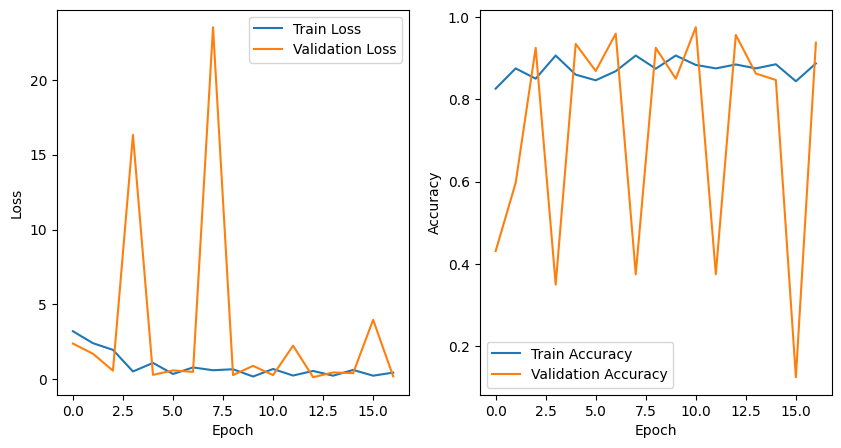

In [22]:
# Formatear el history para visualizarlo
formatted_history = prepare_history_data(history)
# Llamar a la función de plot
plot_training(formatted_history)

En los gráficos obtenidos se siguen mostrando resultados un poco inusuales que pueden indicar, igual que en casos anteriores, varios fenómenos subyacentes en el proceso de aprendizaje de tu red neuronal. En relación al entrenamiento sí se ve que se haya reducido levemente el overfitting al presentar una evolución de accuracy menos variante y alrededor del 90%. Además, se observa como el loss disminuye de la manera esperada. Sin embargo, respecto a la validación, se sigue observando un comportamiento inestable en la pérdida de validación y precisión a lo largo del entrenamiento, a pesar de haber implementado técnicas de regularización como el dropout y la normalización por lotes, además de la ampliación de datos (data augmentation). En este sentido, pese a las técnicas aplicadas los picos pronunciados en las gráficas de validación sugieren que el modelo sigue experimentando dificultades para generalizar sobre datos nuevos. Esto puede ser indicativo de un sobreajuste temporal a ciertos aspectos de los datos de entrenamiento que no representan bien el conjunto de validación. Además, el hecho de que la  precisión de validación también muestre una gran variabilidad, alternando entre mejorar significativamente y luego caer abruptamente  puede deberse a la falta de datos representativos en el conjunto de entrenamiento o a la posible alta complejidad del modelo frente a la diversidad de los datos.

Por ello, seguimos en la situación de que aunque la pérdida de entrenamiento disminuye de manera más estable y la precisión de entrenamiento parece ser alta, la falta de correspondencia con la validación resalta problemas potenciales de generalización. Si no se observaran dichos picos y se suavizaran las gráficas de validación, sí que podríamos afirmar que la precisión de validación alcanzaría  más o menos el mismo valor que la precisión de entrenamiento en la cuarta época, y desde entonces ha ido aumentando al mismo ritmo que la precisión de entrenamiento, lo que significa que el modelo no se ha sobreajustado demasiado y sería capaz de generalizar mejor.

Dado la obtención de estos resultados inusales en el conjunto de validación y las conclusiones obtenidas, parece que el modelo sigue sin conseguir generalizar de la manera esperada debido a una posible existencia de datos no representativos o la posible alta complejidad del modelo, por lo que tras aplicar varias técnicas sin ver resultado se decide probar modelos pre-entrenados con el objetivo de determinar si los resultados mejoran y es efectivamente algo relacionado con el modelo base implementado.